## The HRT for mixed data types (Python implementation)

In [my last post](http://www.erikdrysdale.com/hrt/) I showed how the [holdout random test](https://arxiv.org/abs/1811.00645) (HRT) could be used to obtain valid p-values for any machine learning model by sampling from the conditional distribution of the design matrix. Like the permutation-type approaches used to assess variable importance for decision trees, this method sees whether a measure of performance accuracy declines when a column of the data has its values shuffled. However these ad-hoc permutation approaches lack statistical rigor and will not obtain a valid inferential assessment, even asymptotically, as the non-permuted columns of the data are not conditioned on. For example, if two features are correlated with the data, but only one has a statistical relationship with the response, then naive permutation approaches will often find the correlated noise column to be significant simply by it riding on the statistical coattails of the true variable. The HRT avoids this issue by fully conditioning on the data.

One simple way of learning the conditional distribution of the design matrix is to assume a multivariate Gaussian distribution but simply estimating the precision matrix. However when the columns of the data are not Gaussian or not continuous then this learned distribution will prove a poor estimate of the conditional relationship of the data. The goal is this post is two-fold. First, show how to fit a marginal regression model to each column of the data (regularized Gaussian and Binomial regressions are used). Second, a `python` implementation will be used to complement the `R` code used previously. While this post will use an un-tuned random forest classifier, any machine learning model can be used for the training set of the data.

In [1]:
# import the necessary modules
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
import seaborn as sns

### Split a dataset into a tranining and a test folder

In the code blocks below we load a real and synthetic dataset to highlight the HRT at the bottom of the script.

#### Option 1: South African Heart Dataset

In [2]:
link_data = "https://web.stanford.edu/~hastie/ElemStatLearn/datasets/SAheart.data"
dat_sah = pd.read_csv(link_data)
# Extract the binary response and then drop
y_sah = dat_sah['chd']
dat_sah.drop(columns=['row.names','chd'],inplace=True)
# one-hot encode famhist
dat_sah['famhist'] = pd.get_dummies(dat_sah['famhist'])['Present']
# Convert the X matrix to a numpy array
X_sah = np.array(dat_sah)

Note that the column types of each data need to be defined in the `cn_type` variable.

In [3]:
cn_type_sah = np.where(dat_sah.columns=='famhist','binomial','gaussian')
# Do a train/test split
np.random.seed(1234)
idx = np.arange(len(y_sah))
np.random.shuffle(idx)
idx_test = np.where((idx % 5) == 0)[0]
idx_train = np.where((idx % 5) != 0)[0]

X_train_sah = X_sah[idx_train]
X_test_sah = X_sah[idx_test]
y_train_sah = y_sah[idx_train]
y_test_sah = y_sah[idx_test]

#### Option 2: Non-linear decision boundary dataset

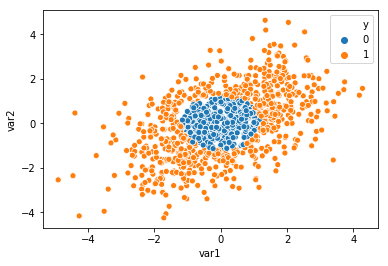

In [4]:
# ---- Random circle data ---- #
np.random.seed(1234)
n_circ = 1000
X_circ = np.random.randn(n_circ,5)
X_circ = X_circ + np.random.randn(n_circ,1)
y_circ = np.where(np.apply_along_axis(arr=X_circ[:,0:2],axis=1,func1d= lambda x: np.sqrt(np.sum(x**2)) ) > 1.2,1,0)

cn_type_circ = np.repeat('gaussian',X_circ.shape[1])

idx = np.arange(n_circ)
np.random.shuffle(idx)
idx_test = np.where((idx % 5) == 0)[0]
idx_train = np.where((idx % 5) != 0)[0]

X_train_circ = X_circ[idx_train]
X_test_circ = X_circ[idx_test]
y_train_circ = y_circ[idx_train]
y_test_circ = y_circ[idx_test]

sns.scatterplot(x='var1',y='var2',hue='y',
                data=pd.DataFrame({'y':y_circ,'var1':X_circ[:,0],'var2':X_circ[:,1]}))

## Function support

The code block below provides a wrapper to implement the HRT algorithm for a binary outcome using a single training and test split. See my previous post for generalizations of this method for cross-validation. The function also requires a `cn_type` argument to specify whether the column is continuous or Bernoulli. The `glm_l2` function implements an L2-regularized generalized regression model for Gaussian and Binomial data using an iteratively re-weighted least squares method. This can generalized for elastic-net regularization as well as different generalized linear model classes. The `dgp_fun` function takes a model with with `glm_l2` and will generate a new vector of the data conditional on the rest of the design matrix.

In [5]:
# ---- FUNCTION SUPPORT FOR SCRIPT ---- #

def hrt_bin_fun(X_train,y_train,X_test,y_test,cn_type):
    
    # ---- INTERNAL FUNCTION SUPPORT ---- #
    
    # Sigmoid function
    def sigmoid(x):
        return( 1/(1+np.exp(-x)) )
    # Sigmoid weightin
    def sigmoid_w(x):
        return( sigmoid(x)*(1-sigmoid(x)) )

    def glm_l2(resp,x,standardize,family='binomial',lam=0,add_int=True,tol=1e-4,max_iter=100):
        y = np.array(resp.copy())
        X = x.copy()
        n = X.shape[0]

        # Make sure all the response values are zeros or ones
        check1 = (~np.all(np.isin(np.array(resp),[0,1]))) & (family=='binomial')
        if check1:
            print('Error! Response variable is not all binary'); #return()
        # Make sure the family type is correct
        check2 = ~pd.Series(family).isin(['gaussian','binomial'])[0]
        if check2:
            print('Error! Family must be either gaussian or binoimal')

        # Normalize if requested
        if standardize:
            mu_X = X.mean(axis=0).reshape(1,X.shape[1])
            std_X = X.std(axis=0).reshape(1,X.shape[1])
        else:
            mu_X = np.repeat(0,p).reshape(1,X.shape[1])
            std_X = np.repeat(1,p).reshape(1,X.shape[1])

        X = (X - mu_X)/std_X

        # Add intercept
        if add_int:
            X = np.append(X,np.repeat(1,n).reshape(n,1),axis=1)

        # Calculate dimensions
        y = y.reshape(n,1)

        p = X.shape[1]
        # l2-regularization
        Lambda = n * np.diag(np.repeat(lam,p))

        bhat = np.repeat(0,X.shape[1])

        if family=='binomial':
            bb = np.log(np.mean(y)/(1-np.mean(y)))
        else:
            bb = np.mean(y)

        if add_int:
            bhat = np.append(bhat[1:p],bb).reshape(p,1)

        if family=='binomial':
            ii = 0
            diff = 1
            while( (ii < max_iter) & (diff > tol) ):
                ii += 1
                # Predicted probabilities
                eta = X.dot(bhat)
                phat = sigmoid(eta)
                res = y - phat
                what = phat*(1-phat)
                # Adjusted response
                z = eta + res/what
                # Weighted-least squares
                bhat_new = np.dot( np.linalg.inv( np.dot((X * what).T,X) + Lambda), np.dot((X * what).T, z) )
                diff = np.mean((bhat_new - bhat)**2)
                bhat = bhat_new.copy()
            sig2 = 0

        else:
            bhat = np.dot( np.linalg.inv( np.dot(X.T,X) + Lambda ), np.dot(X.T, y) )
            # Calculate the standard error of the residuals
            res = y - np.dot(X,bhat)
            sig2 = np.sum(res**2) / (n - (p - add_int))

        # Separate the intercept
        if add_int:
            b0 = bhat[p-1][0]
            bhat2 = bhat[0:(p-1)].copy() / std_X.T # Extract intercept
            b0 = b0 - np.sum(bhat2 * mu_X.T)
        else:
            bhat2 = bhat.copy() / std_X.T
            b0 = 0

        # Create a dictionary to store the results
        ret_dict = {'b0':b0, 'bvec':bhat2, 'family':family, 'sig2':sig2, 'n':n}
        return ret_dict

    # mdl=mdl_lst[4].copy(); x = tmp_X.copy() 
    # Function to generate data from a fitted model
    def dgp_fun(mdl,x):
        tmp_n = mdl['n']
        tmp_family = mdl['family']
        tmp_sig2 = mdl['sig2']
        tmp_b0 = mdl['b0']
        tmp_bvec = mdl['bvec']
        # Fitted value
        fitted = np.squeeze(np.dot(x, tmp_bvec) + tmp_b0)

        if tmp_family=='gaussian':
            # Generate some noise
            noise = np.random.randn(tmp_n)*np.sqrt(tmp_sig2) + tmp_b0
            y_ret = fitted + noise
        else:
            y_ret = np.random.binomial(n=1,p=sigmoid(fitted),size=tmp_n)
        # Return
        return(y_ret)

    # Logistic loss function
    def loss_binomial(y,yhat):
        ll = -1*np.mean(y*np.log(yhat) + (1-y)*np.log(1-yhat))
        return(ll)
    
    # Loop through and fit a model to each column
    mdl_lst = []
    for cc in np.arange(len(cn_type)):
        tmp_y = X_test[:,cc]
        tmp_X = np.delete(X_test, cc, 1)
        tmp_family = cn_type[cc]
        mdl_lst.append(glm_l2(resp=tmp_y,x=tmp_X,family=tmp_family,lam=0,standardize=True))
        
    # ---- FIT SOME MACHINE LEARNING MODEL HERE ---- #
    # Fit random forest
    clf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
    clf.fit(X_train, y_train)
    # Baseline predicted probabilities and logistic loss
    phat_baseline = clf.predict_proba(X_test)[:,1]    
    loss_baseline = loss_binomial(y=y_test,yhat=phat_baseline)

    # ---- CALCULATE P-VALUES FOR EACH MODEL ---- #
    pval_lst = []
    nsim = 250
    for cc in np.arange(len(cn_type)):
        print('Variable %i of %i' % (cc+1, len(cn_type)))
        mdl_cc = mdl_lst[cc]
        X_test_not_cc = np.delete(X_test, cc, 1)
        X_test_cc = X_test.copy()
        loss_lst = []
        for ii in range(nsim):
            np.random.seed(ii)
            xx_draw_test = dgp_fun(mdl=mdl_cc,x=X_test_not_cc)
            X_test_cc[:,cc] = xx_draw_test
            phat_ii = clf.predict_proba(X_test_cc)[:,1]
            loss_ii = loss_binomial(y=y_test,yhat=phat_ii)
            loss_lst.append(loss_ii)
        pval_cc = np.mean(np.array(loss_lst) <= loss_baseline)
        pval_lst.append(pval_cc)

    # Return p-values
    return(pval_lst)

### Get the p-values for the different datasets

Now that the `hrt_bin_fun` has been defined, we can perform inference on the columns of the two datasets created above.

In [6]:
pval_circ = hrt_bin_fun(X_train=X_train_circ,y_train=y_train_circ,X_test=X_test_circ,y_test=y_test_circ,cn_type=cn_type_circ)
pval_sah = hrt_bin_fun(X_train=X_train_sah,y_train=y_train_sah,X_test=X_test_sah,y_test=y_test_sah,cn_type=cn_type_sah)

Variable 1 of 5
Variable 2 of 5
Variable 3 of 5
Variable 4 of 5
Variable 5 of 5
Variable 1 of 9
Variable 2 of 9
Variable 3 of 9
Variable 4 of 9
Variable 5 of 9
Variable 6 of 9
Variable 7 of 9
Variable 8 of 9
Variable 9 of 9


The results below show that the `sbp`, `tobacco`, `ldl`, `adiposity`, and `age` are statistically significant features for the South African Heart Dataset. As expected, the first two variables, `var1`, and `var2` from the non-linear decision boundary dataset are important as these are the two variables which define the decision boundary with the rest of the variables being noise variables.

In [7]:
pd.concat([pd.DataFrame({'vars':dat_sah.columns, 'pval':pval_sah, 'dataset':'SAH'}),
           pd.DataFrame({'vars':['var'+str(x) for x in np.arange(5)+1],'pval':pval_circ,'dataset':'NLP'})])

,vars,pval,dataset
0,sbp,0.000,SAH
1,tobacco,0.000,SAH
2,ldl,0.000,SAH
3,adiposity,0.000,SAH
4,famhist,0.112,SAH
5,typea,1.000,SAH
6,obesity,1.000,SAH
7,alcohol,0.568,SAH
8,age,0.000,SAH
0,var1,0.000,NLP
